
In this notebook, we will try the process of implementing RNN with Keras in order to classify text sentences.

I.   **Firstly**, we'll import useful packages.

II.   **Then**, we'll load the data and create a word embedding matrix using Glove.

III.  **We'll try a simple RNN model** and then we will evaluate its performances.

IV. Finally, we'll use techniques to increase our model's accuracy.

**Task 1:** Setting Fre GPU in this Google Colab notebook.

## Mounting Google Drive locally
**Task 2:** Mount the Google Driver into the Google Colab Driver.


In [1]:
## TYPE YOUR CODE for task 2 here:
import os
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/gdrive')
else:
    print("I'm running on JupyterLab")

Mounted at /content/gdrive


# I. Let import all useful packages.

In [2]:
import os
import random
import datetime
import time
import subprocess
from glob import glob
import operator
import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
import keras

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric
import tensorflow.keras.optimizers as Optimizer
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
import cv2


In [3]:
if 'COLAB_GPU' in os.environ:
    !pip install ipython-autotime
else:
    print("I'm running on JupyterLab")


In [4]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%load_ext tensorboard
%matplotlib inline


time: 5.82 ms


**Task 3**: Copy the dataset from Google Drive into Colab

In [5]:
## TYPE YOUR CODE for task 3 here:
if 'COLAB_GPU' in os.environ:
    !cp "{'/content/gdrive/My Drive/FUNIX_ASM_2/glove.6B.50d.txt.zip'}"  .
    !cp "{'/content/gdrive/My Drive/FUNIX_ASM_2/train.csv.zip'}"  .
    !unzip -q  glove.6B.50d.txt.zip
    !unzip -q  train.csv.zip
    !rm glove.6B.50d.txt.zip
    !rm  train.csv.zip
else:
    print("I'm running on JupyterLab")


time: 20.1 s


# II. Load the data.

## About dataset.
An invalid question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is invalid:

* Has a non-neutral tone.
* Is disparaging or inflammatory.
* Isn't grounded in reality.
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The data includes the question that was asked, and whether it was identified as invalid (target = 1). 

**Task 4**: Load the dataset.
* Load the data from CSV file.
* Remove all the rows with NA values.
* Split the data into 3 set: Training set, validation set and test set (0.9/0.05/0.05, random_seed = 9) with a same ratio of data number beween each class.
* Print out these dataset's description.




In [6]:
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set and test_set(0.90/0.05/0.05) without NA values.
    '''
    ## TYPE YOUR CODE for task 4 here:
    df = pd.read_csv(data_link)
    df.dropna(inplace=True)
    train, val_test = train_test_split(df, test_size=0.1, random_state=9, stratify=df['target'])
    validation, test = train_test_split(val_test, test_size=0.5, random_state=9, stratify=val_test['target'])
    return train, validation, test

train_set, validation_set, test_set = load_data('train.csv')
print(train_set['target'].describe())
print(validation_set['target'].describe())
print(test_set['target'].describe())


count    1.175509e+06
mean     6.187022e-02
std      2.409198e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: target, dtype: float64
count    65306.000000
mean         0.061863
std          0.240908
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64
count    65307.000000
mean         0.061877
std          0.240934
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target, dtype: float64
time: 3.32 s


# Encoding text data.
Let declare some fundamental parameters first:

In [7]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 50 # max number of words in a question to use


time: 1.36 ms


**Task 5:** Encode the dataset using Tokenizer and one-hot encoding vector.
* Encode the text (question_text column) by turning each question text into a list of word indexes using [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) with **max_features** and all the text sentences from the training and the validation set. 
* Turn each list of word indexes into an equal length - **max_len** (with truncation or padding as needed) using [pad_sequences](https://keras.io/preprocessing/sequence/).
* Encode the label (label column) using [to_categorical](https://keras.io/utils/) function on Keras.

In [14]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    ## TYPE YOUR CODE for task 5 here:
    
    tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token=None)
    # Fitting
    tokenizer.fit_on_texts(train_set['question_text'])
    tokenizer.fit_on_texts(validation_set['question_text'])
    
    data = [train_set, validation_set, test_set]
    X = []
    Y = []
    for df in data:
        x = df['question_text']
        x = tokenizer.texts_to_sequences(x)
        x = pad_sequences(x, maxlen=max_len, dtype="int32", padding="pre", truncating="pre", value=0)
        X.append(x)
        y = df['target']
        y = to_categorical(y, num_classes=2, dtype="float32")
        #y = [i[::-1] for i in y]
        #y = np.array(y)
        Y.append(y)
    
    X_tr, X_va, X_te = X
    y_tr, y_va, y_te = Y

    return  X_tr, X_va, X_te, y_tr, y_va, y_te, tokenizer
    
X_tr, X_va, X_te, y_tr, y_va, y_te, tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)


time: 40.2 s


**Task 6**: Create word embedding matrix.
* Firstly, write a function to [load the GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Then, create a word embedding matrix using GloVe dictionary with these parameters:
    - Word embedding matrix shape: (Number of word, embed_size).
    - Embed size: 50.
    - Number of words: The minimum of (max_features, len(word_index)), while word_index is the dictionary of word which contains in tokenizer.
    - If a word occurs in GloVe dictionary, we should take its initialization value as in GloVe dictionary. Otherwise, take a normal random value with mean and std as mean and std of GloVe dictionary value.
    



In [15]:

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## TYPE YOUR CODE for task 6 here:
    GloVe_dict = {}
    with open(GloVe_link, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            word_vector = np.asarray(values[1:], dtype='float32')
            GloVe_dict[word] = word_vector
    return GloVe_dict

GloVe_link = 'glove.6B.50d.txt'
#GloVe_link = 'sample.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)


time: 5.55 s


In [16]:
# Check size of word vector
print(GloVe_dict['the'].shape)
GloVe_dict['the']


(50,)


array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

time: 4.47 ms


In [17]:
def create_embedding_matrix(wordvector_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer from training and validation dataset, number of max features.
    output: Word embedding matrix.
    '''
    
    ## TYPE YOUR CODE for task 6 here:
    number_words = min(len(wordvector_dict), max_features)
    wordvector_embs = np.hstack(wordvector_dict.values())
    mean, std = wordvector_embs.mean(), wordvector_embs.std()
    embedding_matrix = np.random.normal(mean, std, (number_words, embed_size))
    
    for word, i in tokenizer.word_index.items():
        if i >= number_words:
            break
        if word in wordvector_dict:
            embedding_matrix[i] = wordvector_dict[word]
       
    return embedding_matrix

embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


time: 356 ms


In [18]:
# Check result
embedding_matrix.shape

(20000, 50)

time: 2.09 ms


III. Modelling
There are some steps we need to finish:
Build the model.

Compile the model.

Train / fit the data to the model.

Evaluate the model on the testing set.

## Build the model
**Task 7:** We can build an easy model composed of different layers such as:
* [Embedding](https://keras.io/layers/embeddings/) layer with max_features, embed_size and embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/imdb_bidirectional_lstm/) with number of hidden state = 50, dropout_rate = 0.1 and recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense with number of unit = 50, activation = 'relu'.
* Dropout with rate = 0.1.
* Final dense with number of unit = number of class, activation = 'sigmoid'.

In [19]:
def create_model(max_len, max_features, embed_size, embedding_matrix):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    ## TYPE YOUR CODE for task 7 here:
    input_layer = Input((None,))
    embedding_layer = Embedding(input_dim=max_features,
                                output_dim=embed_size,
                                input_length=max_len,
                                weights=[embedding_matrix],
                                mask_zero=True,
                                trainable=False)(input_layer)
    
    bidirectional_layer = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
    #bidirectional_layer = LSTM(1, return_sequences=True, dropout=0.1)(embedding_layer)
                                        
    globalmaxpool_layer = GlobalMaxPool1D()(bidirectional_layer)
                                        
    dense_layer = Dense(units=50, activation='relu')(globalmaxpool_layer)
    
    droput_layer = Dropout(0.1)(dense_layer)
    
    classify_layer = Dense(units=2, activation='sigmoid')(droput_layer)

    model = Model(inputs=input_layer, outputs=classify_layer)
    
    
    return model

model = create_model(max_len, max_features, embed_size, embedding_matrix)


time: 5.82 s


**Task 8:** Compile the model and setup the callback. Then print out the model summary.
* [Compile](https://keras.io/models/model/#compile) the model with Adam Optimizaer, lr = 1e-2, suitable loss for binary classification problem and ["F1-score"](https://github.com/tensorflow/addons/issues/825) as metric.
* Print out the model summary.

In [20]:
def create_f1():
    def f1_function(y_true, y_pred):
        y_true_class = tf.argmax(y_true, axis=1)
        y_pred_class = tf.argmax(y_pred, axis=1)
        tp = tf.reduce_sum(y_true_class * y_pred_class)
        tp = tf.cast(tp, 'float32')
        predicted_positives = tf.reduce_sum(y_pred_class)
        predicted_positives = tf.cast(predicted_positives, 'float32')
        possible_positives = tf.reduce_sum(y_true_class)
        possible_positives = tf.cast(possible_positives, 'float32')
        return tp, predicted_positives, possible_positives
    return f1_function

class F1_Score(Metric):
    def __init__(self, name='new_f1_score', **kwargs):
        super(F1_Score, self).__init__(name=name, **kwargs)
        self.f1_function = create_f1()
        self.tp_count = self.add_weight("tp_count", initializer="zeros")
        self.all_predicted_positives = self.add_weight('all_predicted_positives', initializer='zeros')
        self.all_possible_positives = self.add_weight('all_possible_positives', initializer='zeros')
       
    def update_state(self, y_true, y_pred,sample_weight=None):
        tp, predicted_positives, possible_positives = self.f1_function(y_true, y_pred)
        self.tp_count.assign_add(tp)
        self.all_predicted_positives.assign_add(predicted_positives)
        self.all_possible_positives.assign_add(possible_positives)
    
    def result(self):
        precision = self.tp_count / self.all_predicted_positives
        recall = self.tp_count / self.all_possible_positives
        f1 = 2*(precision*recall)/(precision+recall)
        return f1
    

time: 16.2 ms


In [21]:
def optimize(model):
    '''
    Input: 
        Model.
    Return: 
        Complied model.
    '''
    ## TYPE YOUR CODE for task 8 here:
    model.compile(optimizer=Optimizer.Adam(lr=0.01),
                  loss='binary_crossentropy',
                  #run_eagerly=True,
                  metrics = [F1_Score()]
                 )
    return model

model = optimize(model)
print(model.summary())


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

**Task 9**: Setup callback.
* Create the [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) to save the logs.
* Create the [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) to save the checkpoint with the best accuracy after each epoch.
* Create the [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback with factor=0.3, patience=1 and "Validation F1-score" monitor.
* Create the [early stopping callback](https://keras.io/callbacks/#earlystopping) with patience=7, mode = 'max' and "Validation F1-score" monitor.



In [22]:
def get_best_result(checkpoint_name):
    path = checkpoint_name+'**'
    all_path_files = glob(path)
    results = {}
    for file in all_path_files:
        results[file] = float(file[-9:-5])
    best_file = max(results.items(), key=operator.itemgetter(1))[0]
    return best_file

def callback_model(checkpoint_name, logdir):
    '''
    Input: 
        Best checkpoint name, log dir.
    Return: 
        Callback list, which contains tensorboard callback and checkpoint callback.
    '''
    ## TYPE YOUR CODE for task 9 here:

    logdir = os.path.join(logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
    
    checkpoint_name = checkpoint_name + '-{epoch:02d}-{val_new_f1_score:.3f}.hdf5'
    checkpoint = ModelCheckpoint(checkpoint_name,
                                 monitor='val_new_f1_score',
                                 save_best_only=False,
                                 mode='max',
                                 verbose=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_new_f1_score',
                                  factor=0.3,
                                  patience=1,
                                  verbose=1)
    
    early_stopping = EarlyStopping(patience=7,
                                   monitor='val_new_f1_score',
                                   mode='max',
                                   verbose=1)
    
    callbacks_list = [tensorboard_callback, checkpoint, reduce_lr, early_stopping]
    
    return callbacks_list

#%rmdir /q/s training_logs
checkpoint_name = 'weights-improvement'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'training_logs'
logdir = os.path.join(baseDir, logs_name)
callbacks_list = callback_model(checkpoint_name, logdir)


time: 266 ms


**Task 10:** Train the model.

* Train the model with 20 epochs with batch_size = 4096.
* Return the model with best-checkpoint weights.

*Hint*: Fit the model first, then reload the model (load_model function) with best-checkpoint weights.

In [23]:
def train_model(model, callbacks_list, skip_training=True):
    '''
    Input: 
        Model and callback list,
    Return: 
        Model with best-checkpoint weights.
    '''
    ## TYPE YOUR CODE for task 10 here:
    if not skip_training:
        # Clear old folder
        %rmdir /q/s {logs_name}
        # Clear old file
        path = checkpoint_name + '**'
        all_path_files = glob(path)
        for file in all_path_files:
            os.remove(file)
        # fit model
        model.fit(X_tr, y_tr,
                  validation_data=(X_va, y_va),
                  batch_size=4096,
                  epochs=20,
                  callbacks=callbacks_list)

        del model
        
    best_file = get_best_result(checkpoint_name)
    model = load_model(best_file, custom_objects={'F1_Score':F1_Score()}) 
    return model


time: 5.81 ms


In [ ]:
# Train model
model = create_model(max_len, max_features, embed_size, embedding_matrix)
model = optimize(model)
model = train_model(model, callbacks_list, skip_training=False)


Epoch 1/20
  1/287 [..............................] - ETA: 0s - loss: 0.7395 - new_f1_score: 0.1036WARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
287/287 [==============================] - ETA: 0s - loss: 0.1544 - new_f1_score: 0.2214
Epoch 00001: saving model to weights-improvement-01-0.533.hdf5
287/287 [==============================] - 513s 2s/step - loss: 0.1544 - new_f1_score: 0.2214 - val_loss: 0.1260 - val_new_f1_score: 0.5329
Epoch 2/20
287/287 [==============================] - ETA: 0s - loss: 0.1244 - new_f1_score: 0.5474
Epoch 00002: saving model to weights-improvement-02-0.610.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
287/287 [==============================] - 508s 2s/step - loss: 0.1244 

In [ ]:
f1 = model.evaluate(X_te, y_te)
f1

2041/2041 [==============================] - 58s 29ms/step - loss: 0.1119 - new_f1_score: 0.6293


[0.11188188195228577, 0.629287600517273]

time: 59.7 s


**Task 11:** Show the tensorboard in the notebook.

In [ ]:
## TYPE YOUR CODE for task 11 here:
if 'COLAB_GPU' in os.environ:
    %tensorboard --logdir {logdir}
else:
    proc = subprocess.Popen(["tensorboard", "--logdir", logdir])
    # wait process
    time.sleep(5)
    %tensorboard --logdir {logdir}
    #%tensorboard --logdir {logdir}


Reusing TensorBoard on port 6006 (pid 10980), started 5 days, 13:21:45 ago. (Use '!kill 10980' to kill it.)

time: 5.05 s


**Task 12:** Prediction on test set.

* Complete the get_prediction_classes function.
* Print out the precision, recall and F1 score.

In [ ]:
def get_prediction_classes(model, X, y):
    ## TYPE YOUR CODE for task 13 here:
    '''
    Input: 
        Model and prediction dataset.
    Return: 
        Prediction list and groundtrurth list with predicted classes.
    '''
    groundtruths = np.argmax(y, axis=1) 
    predictions = model.predict(X)
    predictions = np.argmax(predictions, axis=1) 
    return predictions, groundtruths


test_predictions, test_groundtruths = get_prediction_classes(model, X_te, y_te)


time: 39.7 s


In [ ]:
print(precision_score(test_groundtruths, test_predictions))
print(recall_score(test_groundtruths, test_predictions))
print(f1_score(test_groundtruths, test_predictions))


0.6657381615598886
0.6505815392229646
0.6580725907384231
time: 47 ms


**Task 13:** Perform the predicted result on test set using confusion matrix. Remember to show the class name in the confusion matrix.

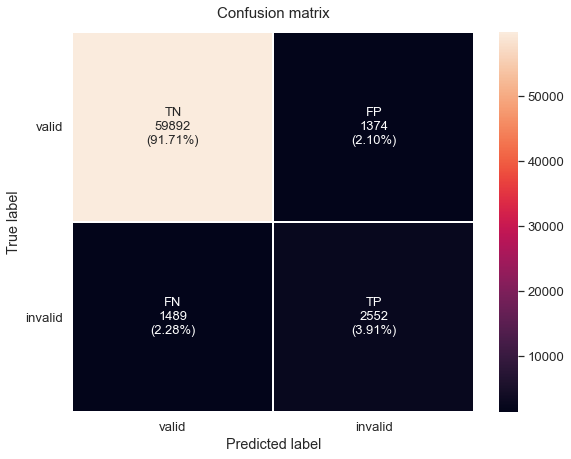

time: 375 ms


In [ ]:
sns.set(font_scale=1.2, style='dark')
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## TYPE YOUR CODE for task 13 here:
    cm = confusion_matrix(groundtruth, predictions, normalize=None)
    cm_rate = cm / np.sum(cm) #confusion_matrix(groundtruth, predictions, normalize='true')
    
    values = ['{0:0.0f}'.format(value) for value in cm.flatten()] 
    percentages = ["{0:.2%}".format(value) for value in cm_rate.flatten()]
    tf_label = ['TN', 'FP', 'FN', 'TP']
    labels = [f'{l}\n{v}\n({p})' for l, v, p in zip(tf_label, values, percentages)]
    labels = np.array(labels).reshape(2, 2)
    
    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=labels, fmt="", annot_kws={"size": 13}, xticklabels=class_names, yticklabels=class_names, linewidths=1) 
    plt.title('Confusion matrix', y=1.02, size=15)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.yticks(rotation=0)
    plt.show()
    
class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)


**Task 14**: Model finetuning - fine tune the model using some of these approachs:
* Increase max epochs, change batch size.
* Replace LSTM by GRU units and check if it changes anything.
* Add another layer of LSTM/GRU, see if things improve.
* Play around with Dense layers (add/# units/etc).
* Find preprocessing rules you could add to improve the quality of the data.
* Find another GloVe dictionary.
Requirement: The F1 score should increase by 2-3%.

#### Dowload new dictionary - spacy (a language_model of 300-dimensional GloVe vectors)

In [25]:
!python -m spacy download en_vectors_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')
time: 3.56 s


In [26]:
# load spacy dict
import en_vectors_web_lg

language_model = en_vectors_web_lg.load()  
spacy_dict = {}
for key, vector in language_model.vocab.vectors.items():
    try:
        word_string = language_model.vocab.strings[key]
        spacy_dict[word_string] = vector

    except KeyError:
        print(key)
        continue
        

4035656307355538346
4183861688597294412
9493573674140310719
11580349482641876976
time: 10.7 s


In [ ]:
# Check
print(' shape of vector', spacy_dict['the'].shape)
spacy_dict['the']

In [37]:
# Init parameters, setup folder
embed_size = 300 
max_features = 50000 
max_len = 100 

checkpoint_name = 'new_weights-improvement'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'new_training_logs'
logdir = os.path.join(baseDir, logs_name)
callbacks_list = callback_model(checkpoint_name, logdir)


time: 4.14 ms


In [38]:
# Create new data and new tokenizer
X_tr, X_va, X_te, y_tr, y_va, y_te, tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)
X_tr.shape

(1175509, 120)

time: 42 s


In [39]:
# Create new embedding maxtrix
spacy_embedding_matrix = create_embedding_matrix(spacy_dict, tokenizer, max_features)
spacy_embedding_matrix.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


(50000, 300)

time: 5.41 s


In [40]:
# Train model with new embedding maxtrix
new_model = create_model(max_len, max_features, embed_size, spacy_embedding_matrix)
new_model = optimize(new_model)
new_model = train_model(new_model, callbacks_list, skip_training=False)


rmdir: failed to remove '/q/s': No such file or directory
rmdir: failed to remove 'new_training_logs': Directory not empty
Epoch 1/20
287/287 [==============================] - ETA: 0s - loss: 0.1302 - new_f1_score: 0.4418
Epoch 00001: saving model to new_weights-improvement-01-0.601.hdf5
287/287 [==============================] - 379s 1s/step - loss: 0.1302 - new_f1_score: 0.4418 - val_loss: 0.1108 - val_new_f1_score: 0.6014
Epoch 2/20
287/287 [==============================] - ETA: 0s - loss: 0.1086 - new_f1_score: 0.6272
Epoch 00002: saving model to new_weights-improvement-02-0.648.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
287/287 [==============================] - 370s 1s/step - loss: 0.1086 - new_f1_score: 0.6272 - val_loss: 0.1059 - val_new_f1_score: 0.6481
Epoch 3/20
287/287 [==============================] - ETA: 0s - loss: 0.1005 - new_f1_score: 0.6575
Epoch 00003: saving model to new_weights-improvement-03-0.659.hdf5

Epoch 00003: R

In [41]:
# Evaluate model
_, f1 = new_model.evaluate(X_te, y_te)
f1

2041/2041 [==============================] - 201s 99ms/step - loss: 0.1022 - new_f1_score: 0.6638


0.6638029217720032

time: 3min 21s
